In [52]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import logging
import csv

def read_inferred_network(inferred_network_file: str) -> dd.DataFrame:
    """
    Loads the melted sparse inferred-network parquet (source_id, peak_id, target_id, score_type, score_value)
    and pivots it back to wide form *including* peak_id in the index.
    """
    melted_ddf = dd.read_parquet(inferred_network_file, engine="pyarrow")

    # Standardize IDs
    melted_ddf["source_id"] = melted_ddf["source_id"].str.upper()
    melted_ddf["target_id"] = melted_ddf["target_id"].str.upper()
    # peak_id probably doesn't need uppercasing but you could if you like:
    # melted_ddf["peak_id"]   = melted_ddf["peak_id"].str.upper()

    # 1) group on THREE id-columns + score_type
    grouped = (
        melted_ddf
        .groupby(["source_id", "peak_id", "target_id", "score_type"])
        ["score_value"]
        .mean()
        .reset_index()
    )

    # 2) pivot in pandas (safe since it's already aggregated)
    pdf = grouped.compute()
    wide = pdf.pivot_table(
        index=["source_id", "peak_id", "target_id"],
        columns="score_type",
        values="score_value",
        aggfunc="first"       # now that each is unique per id-triple
    ).reset_index()

    # 3) back to Dask if you want
    return dd.from_pandas(wide, npartitions=1)

def read_ground_truth(ground_truth_file):
    logging.info("Reading in the ground truth")
    ground_truth = pd.read_csv(ground_truth_file, sep='\t', quoting=csv.QUOTE_NONE, on_bad_lines='skip', header=0)
    ground_truth = ground_truth.rename(columns={"Source": "source_id", "Target": "target_id"})
    return ground_truth

def label_edges_with_ground_truth(inferred_network_dd, ground_truth_df):
    logging.info("Creating ground truth set")
    ground_truth_pairs = set(zip(
        ground_truth_df["source_id"].str.upper(),
        ground_truth_df["target_id"].str.upper()
    ))

    logging.info("Adding labels to inferred network")

    def label_partition(df):
        df = df.copy()  # <-- avoids SettingWithCopyWarning
        tf_tg_tuples = list(zip(df["source_id"], df["target_id"]))
        df.loc[:, "label"] = [1 if pair in ground_truth_pairs else 0 for pair in tf_tg_tuples]
        return df

    inferred_network_dd = inferred_network_dd.map_partitions(
        label_partition,
        meta=inferred_network_dd._meta.assign(label=np.int64(0))
    )

    return inferred_network_dd



In [53]:
def plot_feature_score_histograms(
    features,
    inferred_network1,
    inferred_network2,
    label1_name,
    label2_name
):
    print("\tPlotting feature score histograms")
    
    # materialize only needed columns
    if isinstance(inferred_network1, dd.DataFrame):
        print("\tConverting feature columns from Dask to pandas for plotting")
        inferred_network1 = inferred_network1[features].compute()
    if isinstance(inferred_network2, dd.DataFrame):
        inferred_network2 = inferred_network2[features].compute()

    ncols = 4
    nrows = math.ceil(len(features) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)

    # flatten axes for easy indexing
    axes_flat = axes.flat

    for ax, feature in zip(axes_flat, features):
        # draw into this axis explicitly:
        sns.histplot(
            inferred_network1[feature].dropna(),
            bins=50, alpha=0.7,
            color='#1682b1', edgecolor="#032b5f",
            stat='proportion',
            label=label1_name,
            ax=ax
        )
        sns.histplot(
            inferred_network2[feature].dropna(),
            bins=50, alpha=0.7,
            color="#cb5f17", edgecolor="#b13301",
            stat='proportion',
            label=label2_name,
            ax=ax
        )

        # set titles/labels on the same ax
        ax.set_title(feature, fontsize=14)
        ax.set_xlabel(feature, fontsize=14)
        ax.set_ylabel("Proportion", fontsize=14)
        ax.set_xlim(0, 1)
        ax.tick_params(axis='both', labelsize=12)

    # turn off any leftover empty subplots
    for ax in axes_flat[len(features):]:
        ax.set_visible(False)

    # figure-level legend
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="lower center",
        ncol=2,
        fontsize=14,
        bbox_to_anchor=(0.5, -0.02)
    )
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

In [57]:
ground_truth_file: str = "/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN111_ChIPSeq_BEELINE_Mouse_ESC.tsv"

inferred_network1_file: str = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/combined_inferred_dfs/mESC_combined_inferred_score_df.parquet"
# inferred_network1_file: str = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/mESC/filtered_L2_E7.5_rep2/inferred_grns/inferred_score_df.parquet"

inferred_network2_file: str = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/DS011_mESC/DS011_mESC_sample1/inferred_grns/inferred_score_df.parquet"

inferred_network1_dd = read_inferred_network(inferred_network1_file)
inferred_network2_dd = read_inferred_network(inferred_network2_file)

print(inferred_network1_dd.columns)

: 

	Plotting feature score histograms
	Converting feature columns from Dask to pandas for plotting


KeyboardInterrupt: 

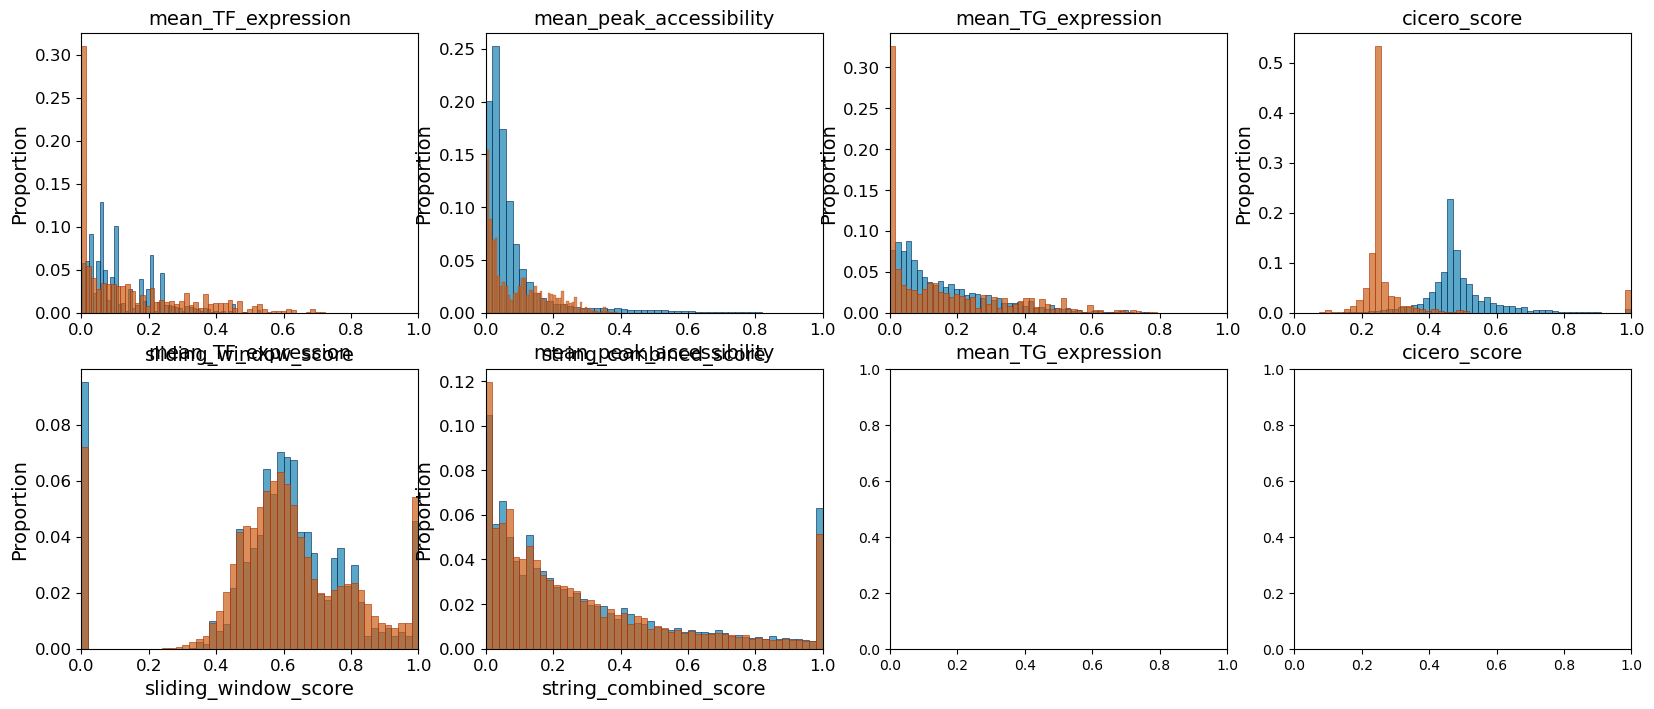

In [56]:
feature_names = [
    'mean_TF_expression',
    'mean_peak_accessibility',
    'mean_TG_expression',
    'cicero_score',
    # 'correlation',
    # 'TSS_dist_score', 
    # 'homer_binding_score', 
    'sliding_window_score', 
    'string_combined_score', 
    'string_experimental_score', 
    'string_textmining_score'
    ]

plot_feature_score_histograms(feature_names, inferred_network1_dd, inferred_network2_dd, "Combined mESC", "DS011 mESC")

	Plotting feature score histograms
	Converting feature columns from Dask to pandas for plotting


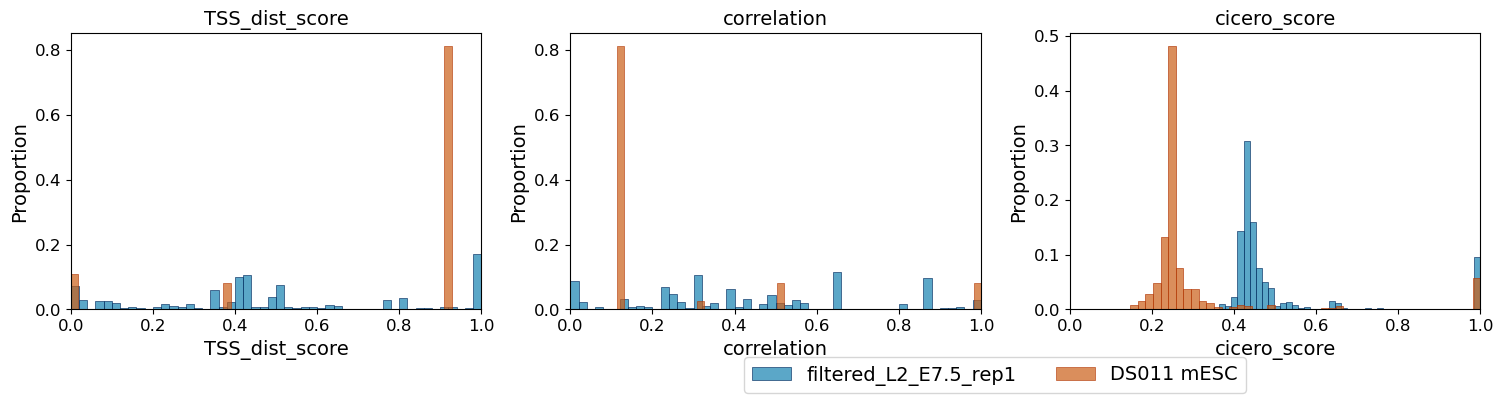

In [ ]:
feature_names = ['TSS_dist_score', 'correlation', 'cicero_score']

plot_feature_score_histograms(feature_names, inferred_network1_dd, inferred_network2_dd, "filtered_L2_E7.5_rep2", "DS011 mESC")